<font style='font-size:3em'>📝 NB02 - Table Scraping  </font>

**PURPOSE**: This Jupyter Notebook contains the data scraped from tables within the 21 links established in NB01 in a dataframe. It also has the analysis I have completed with this data to test my hypothesis.

**LAST REVISION:** 16th November 2023  

## ⚙️ Setting Up

### Packages needed for this NB to run  

In [1]:
import pandas as pd
import requests 
from scrapy import Selector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

- Define my User Header as my LSE Email
- read the URLs extracted from NB01

In [2]:
headers = {'User-Agent': 'm.filip-turner@lse.ac.uk'}
page_urls = pd.read_csv('Data/Elections.csv', usecols=[0]) 

- Create function to scrape election data I want to test my hypothesis
- I noticed that **bolded** elements of the Wikipedia table refered to the highest number or the winning candidate
- Therefore I could split the varables into winning and loosing using a more preice xpath

In [3]:
def scrape_election_data(url, headers):
    """Scrape election data from a single Wikipedia page."""
    response = requests.get(url, headers=headers)
    sel = Selector(text=response.text)
    body = sel.xpath('//table[@class="infobox vevent"]/tbody')
    row = body.xpath('//tr[6]') 

    election_data = {
        'Winning Candidate': row.xpath('//td/table/tbody/tr[2]/td[1]/b/a/text()').get(),
        'Losing Candidate': row.xpath('//td/table/tbody/tr[2]/td[2]/a/text()').get(),
        'Winning Party': row.xpath('//td/table/tbody/tr[3]/td[1]/a/text()').get(),
        'Losing Party': row.xpath('//td/table/tbody/tr[3]/td[2]/a/text()').get(),
        'Winning Electoral Votes': row.xpath('//td/table/tbody/tr[6]/td[1]/b/text()').get(),
        'Losing Electoral Votes': row.xpath('//td/table/tbody/tr[6]/td[2]/text()').get(),
        'Winning Popular Votes': row.xpath('//td/table/tbody/tr[8]/td[1]/b/text()').get(),
        'Losing Popular Votes': row.xpath('//td/table/tbody/tr[8]/td[2]/text()').get(),
        'Winning Percentage': row.xpath('//td/table/tbody/tr[9]/td[1]/b/text()').get(),
        'Losing Percentage': row.xpath('//td/table/tbody/tr[9]/td[2]/text()').get()
    }
    return election_data

- created a function to clean data to avoid repeated code
- round to 1dp and remove unwanted characters

In [4]:
def process_votes(votes):
    """Convert vote strings to integers."""
    return [int(vote.replace(',', '').strip()) if vote and vote.replace(',', '').strip().isdigit() else None for vote in votes]

def process_percentages(percentages):
    """Convert percentage strings to floats."""
    return [round(float(percentage.replace('%', '').strip()), 1) if percentage and percentage.replace('%', '').strip().replace('.', '').isdigit() else None for percentage in percentages]

- used list comprehension to parse through all URLs

In [5]:
election_data = [scrape_election_data(url, headers) for url in page_urls['Link']]

- some issues arose from the fact Wikipedia **Bold** highest values. 

- **there are two elections **2016** and **2000** whereby Trump and Bush won with fewer popular votes than Clinton Gore.**

In [6]:
Electon_table_data = pd.DataFrame(election_data)

Electon_table_data.at[2, 'Winning Popular Votes'] = '62,984,828'
Electon_table_data.at[6, 'Winning Popular Votes'] = '50,456,002'
Electon_table_data.at[2, 'Losing Popular Votes'] = '65,853,514'
Electon_table_data.at[6, 'Losing Popular Votes'] = '50,999,897'
Electon_table_data.at[2, 'Winning Percentage'] = '46.1%'
Electon_table_data.at[6, 'Winning Percentage'] = '47.9%'
Electon_table_data.at[2, 'Losing Percentage'] = '48.2%'
Electon_table_data.at[6, 'Losing Percentage'] = '48.4%'
Electon_table_data.at[0, 'Winning Party'] = 'None'
Electon_table_data.at[0, 'Losing Party'] = 'None'

- I wanted to create year column by extracting the year from URls
- I also apply the cleaning function here

In [7]:
Electon_table_data['Year'] = [
    int(url.split('/')[-1].split('_')[0]) if url.split('/')[-1].split('_')[0].isdigit() else None
    for url in page_urls['Link']
]
Electon_table_data['Winning Electoral Votes'] = process_votes(Electon_table_data['Winning Electoral Votes'])
Electon_table_data['Losing Electoral Votes'] = process_votes(Electon_table_data['Losing Electoral Votes'])
Electon_table_data['Winning Popular Votes'] = process_votes(Electon_table_data['Winning Popular Votes'])
Electon_table_data['Losing Popular Votes'] = process_votes(Electon_table_data['Losing Popular Votes'])
Electon_table_data['Winning Percentage'] = process_percentages(Electon_table_data['Winning Percentage'])
Electon_table_data['Losing Percentage'] = process_percentages(Electon_table_data['Losing Percentage'])

- I create my DF and export as CSV to /Data file
- I move 'Year" to first column

In [8]:
cols = Electon_table_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
Electon_table_data = Electon_table_data[cols]

Electon_table_data.to_csv('Data/Election_table_data.csv', index=False)


## ⚙️ Analysis of Table Data

**Plotting Winning vs Losing Electoral Votes**

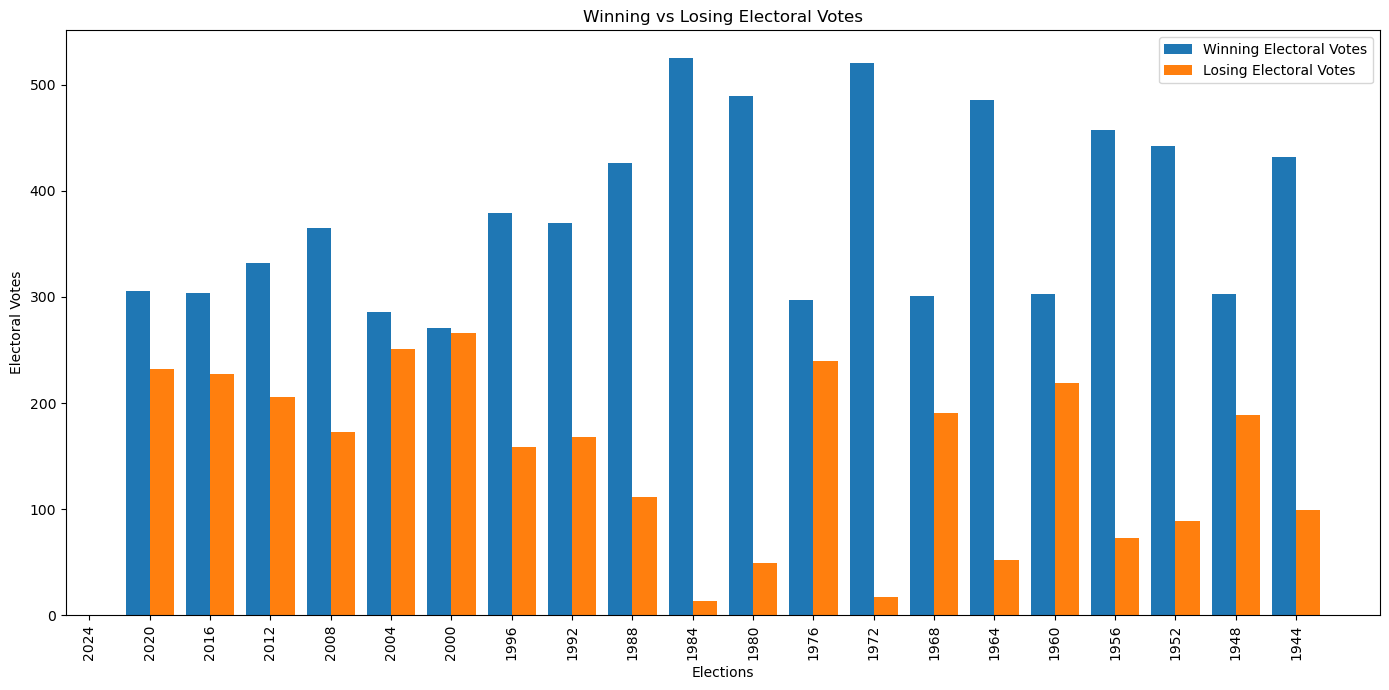

In [9]:
plt.figure(figsize=(14, 7))

plt.bar(Electon_table_data.index - 0.2, Electon_table_data['Winning Electoral Votes'], width=0.4, label='Winning Electoral Votes')

plt.bar(Electon_table_data.index + 0.2, Electon_table_data['Losing Electoral Votes'], width=0.4, label='Losing Electoral Votes')

plt.xlabel('Elections')
plt.ylabel('Electoral Votes')
plt.title('Winning vs Losing Electoral Votes')
plt.xticks(Electon_table_data.index, Electon_table_data['Year'], rotation=90)
plt.legend()

plt.tight_layout()
plt.savefig('Analysis/Popular_Vote_margin.png')

### 📖 Takeaways from bar chart

- This allows easy visualisation of the elctoraal vote differences between winning and losing candidates in each election.

In [10]:
print('The mean winning electoral votes is', Electon_table_data['Winning Electoral Votes'].mean())

The mean winning electoral votes is 379.7


**Vote Margins for 1944-2020 elections in Line Graph:**

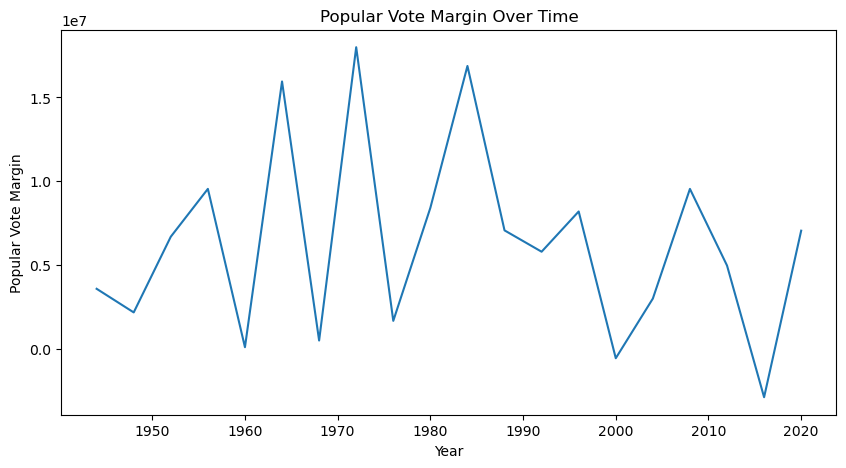

In [11]:
df = pd.read_csv('Data/Election_table_data.csv')

df = df.dropna(subset=['Year', 'Winning Candidate', 'Losing Candidate'])  

df['Popular_Vote_Margin'] = df['Winning Popular Votes'] - df['Losing Popular Votes']
average_margin = df['Popular_Vote_Margin'].mean()

plt.figure(figsize=(10, 5))
sns.lineplot(x='Year', y='Popular_Vote_Margin', data=df)
plt.title('Popular Vote Margin Over Time')
plt.xlabel('Year')
plt.ylabel('Popular Vote Margin')
plt.savefig('Analysis/Popular_Vote_margin.png')


### 📖 Takeaways from Vote Margin over time

- The vote margin tells us how close the election ultimatly was.
- we can clearly infer that elections where the margin is close to 0 such as 2016 were extremely close elections compared with those pushing up to 1.6 such as 1968.
- the vote margin is key for understanding my hypothesis about closeness and turnout.

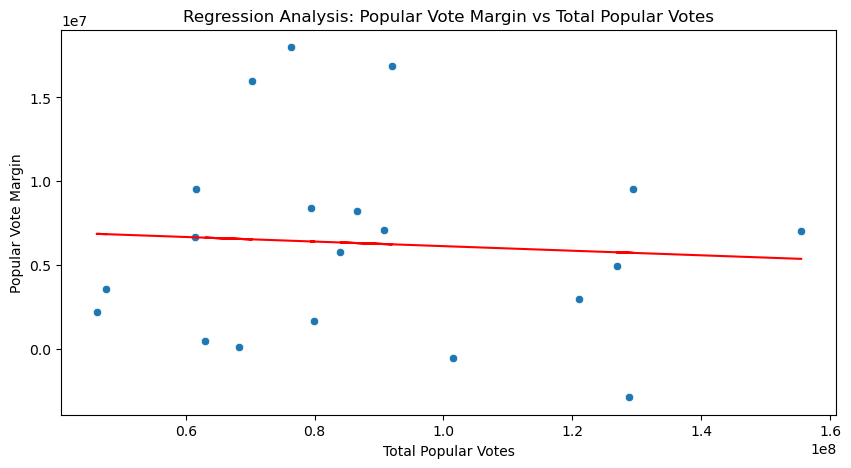

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

df = pd.read_csv('Data/Election_table_data.csv')

df = df.dropna(subset=['Year', 'Winning Candidate', 'Losing Candidate'])

df['Popular_Vote_Margin'] = df['Winning Popular Votes'] - df['Losing Popular Votes']
df['Total_Popular_Votes'] = df['Winning Popular Votes'] + df['Losing Popular Votes']

X = df['Total_Popular_Votes']
y = df['Popular_Vote_Margin']
X = sm.add_constant(X) 

model = sm.OLS(y, X).fit()

predictions = model.predict(X)

plt.figure(figsize=(10, 5))
sns.scatterplot(x='Total_Popular_Votes', y='Popular_Vote_Margin', data=df)
plt.plot(df['Total_Popular_Votes'], predictions, color='red') # regression line
plt.title('Regression Analysis: Popular Vote Margin vs Total Popular Votes')
plt.xlabel('Total Popular Votes')
plt.ylabel('Popular Vote Margin')

plt.savefig('Analysis/Regression_Popular_Vote_Margin_vs_Total_Popular_Votes.png')



In [13]:
correlation = df['Total_Popular_Votes'].corr(df['Popular_Vote_Margin'])

print(f"The correlation coefficient between total popular votes and popular vote margin is: {correlation}")


The correlation coefficient between total popular votes and popular vote margin is: -0.0709726086563203


### 📖 Takeaways from Regression Analysis

**Summary of Regression Analysis Results**
Project Context

This regression analysis is part of a larger project examining trends and relationships in U.S. presidential election data. Specifically, the analysis focused on understanding the relationship between the total popular votes and the popular vote margin in US Presidential elections.

*Analysis Overview*

A linear regression model was employed to assess whether the total number of popular votes of *Republican and Democrat parties* in elections from 1944-2024 can help predict the size of winning margins by which candidates won. The hypothesis was that a greater voter turnout - for the two major parties - would indicate a polarising election whereby margins would be smaller and people feel their votes matter more. The dataset comprised 20 observations, reflecting different presidential election from 1944-2020.

*Key Findings*

Model Fitness: The R-squared value of the model is 0.005, indicating that only 0.5% of the variance in the popular vote margin is explained by the total popular votes. This suggests a very weak explanatory power of the model.
Statistical Significance: The p-value associated with the Total_Popular_Votes variable is 0.766. This is well above the common significance level of 0.05, indicating that there is no statistically significant relationship between the total popular votes and the popular vote margin.
Coefficient Analysis: The coefficient for Total_Popular_Votes is -0.0136, but given the lack of statistical significance, this finding is not reliable for predictive purposes.
Model Reliability Concerns: The condition number is large (2.97e+08), hinting at possible multicollinearity or other numerical problems that might affect the reliability of the regression model.
Interpretation

The analysis does not support the hypothesis that the total popular votes can reliably predict the margin of victory in U.S. presidential elections. The very low R-squared value coupled with the high p-value for the key variable suggests that other factors not included in the model might play a more significant role in determining the popular vote margin.

The high condition number also suggests that the model might suffer from multicollinearity, where independent variables are highly correlated, potentially skewing the results. This indicates a need for further investigation, possibly including additional variables or employing different modeling techniques.

The correlation coefficient is close to zero at -0.0709726086563203, suggesting a slighly negative relationship like hypothesised but not significant. 


The current linear regression analysis does not provide sufficient evidence to conclude a significant predictive relationship between total popular votes and popular vote margin in U.S. presidential elections. 

**PURPOSE**: This Jupyter Notebook contains the data scraped from tables within the 21 links established in NB01 in a dataframe. It also has the analysis I have completed with this data to test my hypothesis.

- The dataframe from this NB is essential for my analysis and to test my hypothesis. I required all the data I collected.
- The bar chart is a useful visualiation to give an overview of closenss of elections since the Second World War.
- The popular vote margin allows me to formally test my hypothesis with the regression. 
- While the regression means i find no statistical significance between total popular votes and winning margins, it gives a useful framework where a greater data volume and added variables would give more light.  